# Red Convolucional

In [3]:
import keras
import keras.backend as TF

In [4]:
flt_type = TF.floatx()

### Dígitos de la DB MNIST



1.   Leer datos
2.   Normalizar datos
3.   Dimensionarlos adecuadamente

Las redes convolucionales de 2D, asumen que los inputs son un set de imágenes con tamaño #de renglones x #de columnas, y varios canales que codifican el color. Los daotos entonces tiene que estar en formato de tensor de dimensión 4 de la forma 
${(\#datos*\#renglones*\#columnas*\#canales)}$.

Es decir ${(alto\ de\ imagen,ancho\ de\ imagen,canales\ de\ imagen)}$. Ya que las imagenes son en escala de grises (1 canal), hay que agregar una dimensión extra al tensor del numero de canales y debe ser =1

In [5]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images,train_labels),(test_images,test_labels) = mnist.load_data()
train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype(flt_type)/255

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype(flt_type)/255

11490434/11490434 [==============================] - 2s 0us/step


Entonces convertimos las etiquetas (labels) con valores enteros a categóricos (variables indicadoras)

In [6]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Extracción de características mediante NN convolucional

La red propuesta es secuencial, es decir, los datos se procesan por una capa que alimenta a la siguiente hasta llegar a la capa de output. No hay retroalimentación o recurrencias (que la capa de output se regrese a una capa previa).
El objetivo de esta red es diseñar filtros para que dados los parches de la imagen de entrada, reproducir el output conocido.
Hay que tomar en cuenta que aunque la red está pensada para realizar diferentes tareas (extraer rasgos y clasificar), la red se va a entrenar en su set. 

In [7]:
from keras import layers
from keras import models

convNN = models.Sequential()

La primera capa añadida es *Conv2D* con los siguientes parámetros:


keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)


*   Filters = dimensión del output space (# de filtros de convolución que implementará la capa)
*   kernel_size = dimensiones de los filtros ${H^{(i)}}$. Si se da un solo valor, significa que son iguales en todas las dimensiones.
*   strides = entero o tupla de dos enteros con el paso de convolusión en cada dimensión
*   padding = {"valid","same"} indican si el resultado tendrá los mismos renglones y columnas que el input o si la convolución solo se aplica sobre datos válidos (reduce bordes).
*   data_format = {"channels_last","channels_first"} indica si los datos estan en formato con los canales al inicio o al final.
*   dilation_rate = entero o tupla de dos enteros indicando la dilatación de la salida en cada dimensión.
*   activation: función de activación.
*   use_bias: boolean que indica si se usa vector de sesgo.
*   kernel_initializer = método de inicialización de los pesos del filtro (matriz).
*   bias_initializer = método de inicialización de los pesos del vector de sesgo.
*   kernel_regularizer = método de regularización de los pesos del filtro.
*   bias_regularizer = método de regularización de los pesos del vector de sesgo.
*   kernel_constraint= restricción sobre los pesos de la matriz kernel (peso de los filtros)
*   bias_constraint= restricción de los pesos del vector de sesgo.

El resultado será de la capa de convolución será de 4 canales, ya que se tiene el batch_size, alto de imagen, ancho de imagen y canales de imagen [filtros]). Con esto se espera lo siguiente:


*   La información relevante en forma de relaciones espaciales de la imagen de entrada se codifique en forma de respuesta en algunos canales.
*   Los pixeles vecinos tengan respuestas similares.
*   Las respuestas altas se asocien con filtros entonados a detectar características relevantes.

Por eso, para resaltar la información relevante al output de la CNN aplicamos un proceso de *pooling* o agrupado con la capa *MaxPooling2D*:

keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

*   pool_size= entero o tupla indicando las dimensiones de la ventana sobre el que se seleccionará la máxima respuesta
*   strides= entero o tupla indicando el paso (default=pool_size)
*   padding = {"valid","same"} indican si el resultado tendrá los mismos renglones y columnas que el input o si la convolución solo se aplica sobre datos válidos (reduce bordes).
*   data_format= {'channels_last'(default),'channels_first'}



In [8]:
convNN.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

In [9]:
convNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

La estrategia es transformar la información espacial en detección (respuesta) de filtros. Por lo que las dimensiones del tensor que se procesa se estrechan espacialmente a la vez que se agregan filtros.
La respuesta de la última capa se puede entender como las características extraidas del vector de entrada.
La siguiente etapa es alimentar, con las características extraidas, una red multicapa para realizar la clasificación.

### Clasificación mediante una red multicapa



1.   Pasar el tensor de rasgos calculada por la etapa previa a un vector unidimensional. Esto se hace con la capa *Flatten*, cuya definición se da por 
keras.layers.Flatten(data_format=None) no requiere parámetros.



In [ ]:
convNN.add(layers.Flatten())

2. Agregamos una red similar con arquitectura similar a la que usamos para clasificar los dígitos del dataset. Esta etapa se compone con dos capas *Dense*, y la de salida es un vector de dimensión 10. En la primera capa oculta pondremos menos neuronas, pues los rasgos relevantes se han conservado y la información no relevante se deshecha.

In [ ]:
convNN.add(layers.Dense(units=64, activation='relu'))
convNN.add(layers.Dense(units=10, activation='softmax'))

In [ ]:
convNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)              

El número de parámetros totales a entrenar es menor a la red multicapa. 
Entonces compilamos en modelo (definimos los parámetros de la etapa de entrenamiento).

In [ ]:
convNN.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

Y procedemos a entrenar.

In [ ]:
import time
tic = time.time()

convNN.fit(x=train_images,
           y=train_labels,
           epochs=5,
           batch_size=64,
           verbose=2)

print('seconds=',time.time()-tic)

Epoch 1/5
938/938 - 58s - loss: 0.1808 - accuracy: 0.9436 - 58s/epoch - 62ms/step
Epoch 2/5
938/938 - 61s - loss: 0.0476 - accuracy: 0.9858 - 61s/epoch - 65ms/step
Epoch 3/5
938/938 - 57s - loss: 0.0339 - accuracy: 0.9891 - 57s/epoch - 60ms/step
Epoch 4/5
938/938 - 55s - loss: 0.0240 - accuracy: 0.9924 - 55s/epoch - 58ms/step
Epoch 5/5
938/938 - 55s - loss: 0.0188 - accuracy: 0.9938 - 55s/epoch - 58ms/step
seconds= 324.59025955200195


### Evaluación del modelo

In [ ]:
test_loss,test_accuracy = convNN.evaluate(test_images,test_labels)
print("Loss: ",test_loss)
print("Accuracy: ",test_accuracy)

313/313 [==============================] - 3s 11ms/step - loss: 0.0253 - accuracy: 0.9927
Loss:  0.025305161252617836
Accuracy:  0.9926999807357788


### Confussion Matrix

In [ ]:
import numpy as np

test_predicted_labels = convNN.predict(test_images)
test_true_labels = np.argmax(test_labels,axis=1)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

313/313 [==============================] - 4s 11ms/step


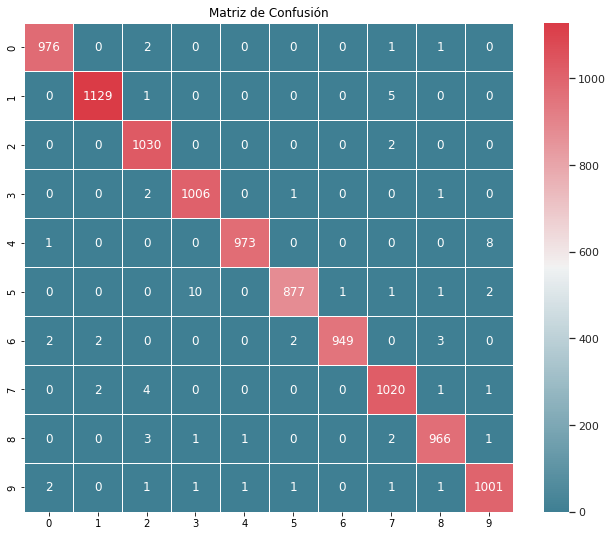

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score 
from sklearn.metrics import f1_score, cohen_kappa_score
import seaborn as sns 

C = confusion_matrix(test_true_labels,test_predicted_labels)

f,ax=plt.subplots(figsize=(11,9))
sns.set()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión')
plt.show()